# Heart data

In this journal, we try to minimize false negatives and maximize precision on a heart disease data set. Since the context of this problem is medical and would have highly undesirable consequences if patients do not receive medical attention when needed, we would like to decrease these cases while also having general high precision across all cases.

### Imports

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

from xgboost import XGBClassifier

### Read in data

In [128]:
df = pd.read_csv("heart.csv")

############## INFO ###############

    age
    sex
    chest pain type (4 values)
    resting blood pressure
    serum cholestoral in mg/dl
    fasting blood sugar > 120 mg/dl
    resting electrocardiographic results (values 0,1,2)
    maximum heart rate achieved
    exercise induced angina
    oldpeak = ST depression induced by exercise relative to rest
    the slope of the peak exercise ST segment
    number of major vessels (0-3) colored by flourosopy
    thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
    The names and social security numbers of the patients were recently removed from the database, replaced with dummy values.

#################################

### Data analysis

Though there are 723 duplicates in the data set that we would normally drop, in this case, we assume the duplicates are patients with the same medical readings, which could reflect reality.

Outliers, calculated with the z-score, are interesting here. There are 56 rows that contain values that could be considered extreme. Again, considering the context, we assume these outliers could be helpful in our real-life situation where patients might present with "weird" values and we'll keep the outliers for now.

In [65]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 969 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       969 non-null    int64  
 1   sex       969 non-null    int64  
 2   cp        969 non-null    int64  
 3   trestbps  969 non-null    int64  
 4   chol      969 non-null    int64  
 5   fbs       969 non-null    int64  
 6   restecg   969 non-null    int64  
 7   thalach   969 non-null    int64  
 8   exang     969 non-null    int64  
 9   oldpeak   969 non-null    float64
 10  slope     969 non-null    int64  
 11  ca        969 non-null    int64  
 12  thal      969 non-null    int64  
 13  target    969 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 145.8 KB


In [67]:
def find_outliers(df: pd.DataFrame):
    """Find extreme values by calculating the z-score.
    Returns set of indices of outliers in a dataframe"""
    outliers = set()
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        for index, value in df[column].items():
            z_score = (value - mean) / std
            if z_score < -3 or z_score > 3:
                outliers.add(index)
    return outliers

def analyze_data(df: pd.DataFrame, dataset_label: str="Data set 1"): 
    """
    Print out analysis data about a data set given a dataframe
    and the data set label to be printed out
    """
    print(dataset_label)
    print(df.describe(include="all"))

    # Find missing values
    n_values = len(df)

    for column in df.columns:
        n_col_values = df[column].count()
        if n_col_values != n_values:
            print(f"{column} missing {abs(n_col_values - n_values)} values")

    # Find number of rows with duplicates
    print(f"Duplicates: {df.duplicated().sum()}")

    # Find outliers
    outliers = find_outliers(df)
    
    print(f"Extreme value indices: {outliers if len(outliers) > 0 else 'None'}")
    print(f"outliers count: {len(outliers)}")
    print("\n")

In [86]:
analyze_data(df.drop(columns="target"), "Heart data")

Heart data
               age          sex  ...           ca         thal
count  1025.000000  1025.000000  ...  1025.000000  1025.000000
mean     54.434146     0.695610  ...     0.754146     2.323902
std       9.072290     0.460373  ...     1.030798     0.620660
min      29.000000     0.000000  ...     0.000000     0.000000
25%      48.000000     0.000000  ...     0.000000     2.000000
50%      56.000000     1.000000  ...     0.000000     2.000000
75%      61.000000     1.000000  ...     1.000000     3.000000
max      77.000000     1.000000  ...     4.000000     3.000000

[8 rows x 13 columns]
Duplicates: 723
Extreme value indices: {128, 641, 393, 521, 267, 526, 14, 151, 665, 158, 417, 290, 294, 296, 428, 685, 686, 175, 688, 559, 179, 52, 54, 55, 958, 831, 192, 833, 450, 319, 69, 326, 329, 970, 464, 208, 465, 83, 340, 597, 348, 734, 481, 993, 996, 613, 743, 359, 749, 242, 246, 889, 378, 123, 508, 893}
outliers count: 56




# Training using XGBClassifier

We get an accuracy score of 99%, which is really great! Clearly this dataset behaves very well. There was, however, a small amount of false negatives, which we would like to avoid even at the cost of accuracy.

Accuracy: 0.9853658536585366


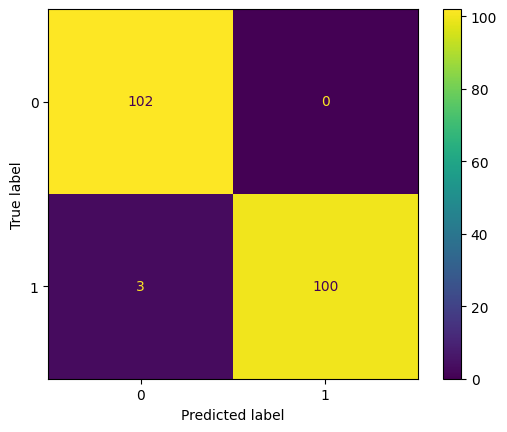

In [108]:
X = df.drop(columns="target")
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = XGBClassifier()

xgb_clf.fit(X_train, y_train)

predictions = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions)

print(f"Accuracy: {accuracy}")
print(conf_matrix)


### Grid search to find best params

Let's use grid search to find the best parameters to tune our classifier with in the hopes of reducing the false negatives.

In [70]:
model = XGBClassifier(objective="binary:logistic", eval_metric="aucpr")

param_grid = {
    "n_estimators": [500],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5, 7, 10],
    "subsample": [1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "gamma": [0]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring="recall", verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters", best_params)
print("Best accuracy:", best_score)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_

### Not helpful

Unfortunately, the best model does not fare any better with false negatives.

Accuracy: 0.9853658536585366


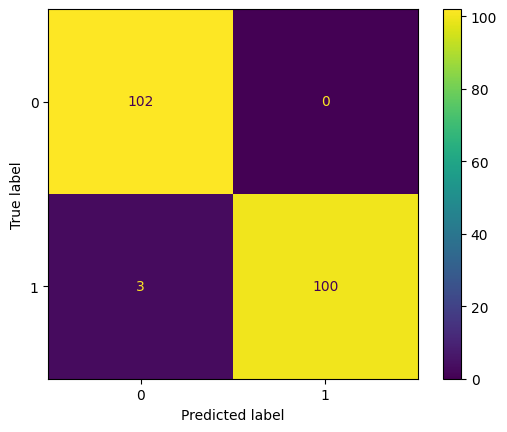

In [116]:
# Didn't help with results
best_model = grid_search.best_estimator_
best_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, best_pred)
print(f"Accuracy: {accuracy}")
print(ConfusionMatrixDisplay.from_predictions(y_test, best_pred))

### Lower the threshold

The aim here was to use XGBoost.predict_proba to return the probabilities of a test data point being labelled as a 1. If we lower the probabilty down from the default, which is 0.5, we might be able to favor false positives instead of false negatives. In other words, we would label more patients as falsely having heart disease than those who falsely are health. This approach can be helpful when we would rather have patients recieve unecessary medical attention than dying.

However, lowering the threshold didn't help and only increased the likelihood of labeling true negatives as false positives. 

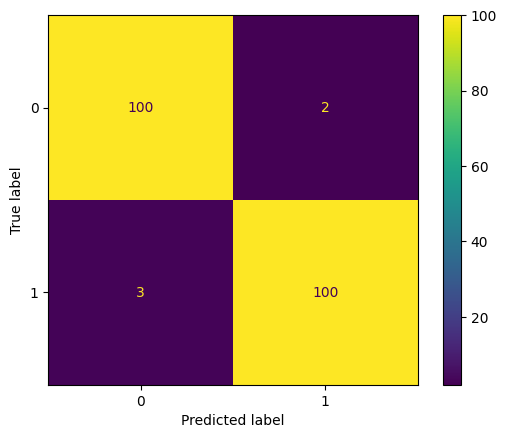

In [130]:
## Didn't help either

# Predict probabilities of being 1
y_probs = xgb_clf.predict_proba(X_test)[:, 1] # returns probabilities of being a [0, 1]

# Adjust threshold to favor false positives
threshold = 0.1  # Example threshold, adjust based on validation set performance
y_pred_adjusted = (y_probs >= threshold).astype(int)

# Evaluate the adjusted predictions

print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred_adjusted))

### Finally dealing with outliers

It could be that the three mislabeled cases are actually outliers in our data. When we compare the cross-validation score for the whole data set, we get an average of 99.3%, which improves slightly to 99.6% when we remove the outliers. In our case, it seems that removing outliers can improve our model, albeit very slightly.

In our cross-validation attempts, four out of five test-train splits produce a 100% accuracy for the data set without outliers, compared to three out of five 100% accuracy runs on the whole data set. Thus, removing outliers seems to produce an improvement in our model and will often eliminate false negatives while also yielding high performance across the board.

In [127]:
# Find cross validate score for whole data set
scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5)
print(f"cross validate scores: {scores}")

avg = np.average(scores)
print(f"average: {avg}")

cross validate scores: [0.9804878  1.         1.         1.         0.98536585]
average: 0.9931707317073171


In [125]:
# Find cross validate score for data set without outliers
outliers = find_outliers(df)

df_no_outliers = df.drop(index=outliers)

X_no_outliers = df_no_outliers.drop(columns="target")
y_no_outliers = df_no_outliers["target"]

scores = cross_val_score(grid_search.best_estimator_, X_no_outliers, y_no_outliers, cv=5)
print(f"cross validate scores: {scores}")

avg = np.average(scores)
print(f"average: {avg}")

cross validate scores: [1.         1.         1.         1.         0.98445596]
average: 0.9968911917098445
